# Leg mapping

Within this notebook I will try and analyse, how much of a difference there is on the leg mapping if we dont use the DFU+service strategy. 

The reason for this is that the forecasting would probabily be alot better if the DFU definition does not include the service code.

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 7]

I have performed the leg mapping both with and without the service code strategy.

In [2]:
file_w_service = "data/leg_mapping_w_service.parquet"
file_wo_service = "data/leg_mapping_wo_service.parquet"

df_w = pd.read_parquet(file_w_service)
df_wo = pd.read_parquet(file_wo_service)

In [60]:
df_w = df_w.query("leg_mapping_strategy == 'lopfi_dipla_leg_departure_service'")

Now I am only looking at the ODs, where the `lopfi_dipla_leg_departure_service` strategy was used. 

And then I want to look into the ODs where we have gotten a different mapping compared to just using the `lopfi_dipla` strategy.

In [83]:
df_w2 = df_w[[
    "dfu_origin_port", "dfu_destination_port", "filed_service",
    "etd_week_sunday", "dfu_cargo_type", "route_cd", "horizon_days", "ffe_total",
    'leg_departure_service', 'leg_departure_service_direction',
       'leg_origin_terminal', 'leg_departure_voyage', 'leg_departure_datetime',
       'leg_destination_terminal', 'leg_arrival_voyage',
       'leg_arrival_datetime', 'leg_departure_date_proforma_utc'
]]
df_wo2 = df_wo[[
    "dfu_origin_port", "dfu_destination_port", "filed_service",
    "etd_week_sunday", "dfu_cargo_type", "route_cd", "horizon_days", "ffe_total",
    'leg_departure_service', 'leg_departure_service_direction',
       'leg_origin_terminal', 'leg_departure_voyage', 'leg_departure_datetime',
       'leg_destination_terminal', 'leg_arrival_voyage',
       'leg_arrival_datetime', 'leg_departure_date_proforma_utc'
]]

tmp = (
    df_w2
#     .head(1000)
    .merge(df_wo2, how="left", on=[
        "dfu_origin_port", "dfu_destination_port", "filed_service",
        "etd_week_sunday", "dfu_cargo_type", "route_cd", "horizon_days", "ffe_total",
        'leg_departure_service', 'leg_departure_service_direction',
        'leg_origin_terminal', 'leg_departure_voyage', 'leg_departure_datetime',
        'leg_destination_terminal', 'leg_arrival_voyage',
        'leg_arrival_datetime', 'leg_departure_date_proforma_utc'
    ], indicator=True)
)

In [110]:
dfu = tmp[[
    "dfu_origin_port", "dfu_destination_port", "filed_service",
    "etd_week_sunday", "dfu_cargo_type", "route_cd", "_merge", "ffe_total",
]].drop_duplicates()

dfus_both = (
    dfu.query("_merge == 'both'")
)

num_dated_dfus_mapped_differently = (
    dfu.query("_merge == 'left_only'")
)

print(f"Number of differently mapped dated ODs: {num_dated_dfus_mapped_differently.shape[0]}")
print(f"Which correspond to: {num_dated_dfus_mapped_differently.shape[0] / dfu.shape[0] * 100:0.2f}% of all dated DFUs")
print()
print(f"Number of differently mapped FFEs: {num_dated_dfus_mapped_differently['ffe_total'].sum():0.2f}")
print(f"Which correspond to: {num_dated_dfus_mapped_differently['ffe_total'].sum() / dfu['ffe_total'].sum() * 100:0.2f}% of all dated DFUs FFE")

Number of differently mapped dated ODs: 5075
Which correspond to: 2.08% of all dated DFUs

Number of differently mapped FFEs: 18154.60
Which correspond to: 2.62% of all dated DFUs FFE


So it seems that not of lot of FFE/DFUs are mapped differently by deleting the `lopfi_dipla_leg_departure_service` strategy.

Also please note, that mapped differently does not mean wrong necessarily. 

Not let us look into how big these dfus are, which are mapped differently.

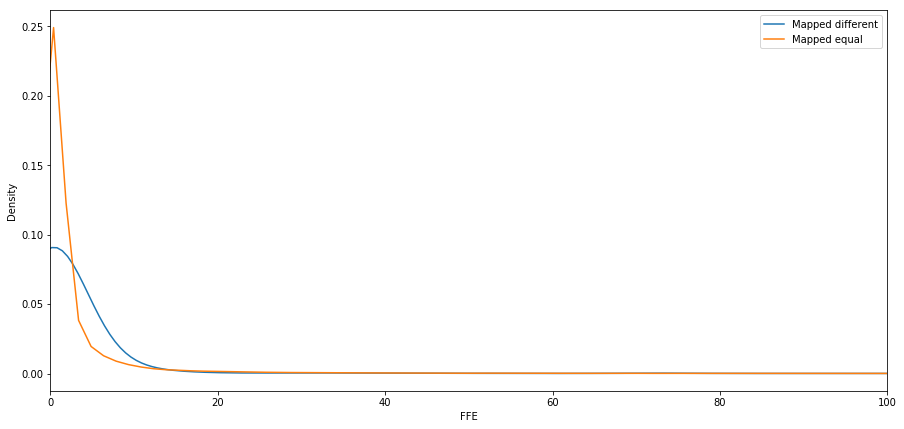

In [118]:
fig, ax = plt.subplots()

num_dated_dfus_mapped_differently["ffe_total"].plot.density(ax=ax, label="Mapped different")
dfus_both["ffe_total"].plot.density(ax=ax, label="Mapped equal")

plt.xlim(0, 100)
plt.xlabel("FFE")
plt.legend();

Let us also look into the percentiles to give us a better picture.

In [119]:
num_dated_dfus_mapped_differently["ffe_total"].describe()

count    5075.000000
mean        3.577260
std        21.934536
min         0.000000
25%         0.000000
50%         0.000000
75%         0.500000
max       314.942589
Name: ffe_total, dtype: float64

In [120]:
dfus_both["ffe_total"].describe()

count    238761.000000
mean          2.827792
std          14.810352
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         746.267900
Name: ffe_total, dtype: float64